# Recurrent Neural Network


### From Assignment Brief:
The goal of this project is to build a next-word predictor, given a sequence of words. <br>
The input to your model is a sequence of words of any length (could be one word,
could be five words, etc.). <br>
The output of your model is a word that follows that sequence of words. <br>
In principle, given an input to your model, you can ask your model to predict the next
ten words, by asking your model to predict the next word ten times. <br>
To test your model, you must apply the following ten example sequences of words as inputs: <br>
You can ask your model to predict the next ten words, given each input. For example: (Seed text **bolded**) <br><br>
Model 1: <br>
**embrace each day** for morning's potential is a blank canvas seize it with <br>
**radiate some** gratitude and watch as the universe conspires to bring you <br>
**believe that** yourself and let your heart's whispers guide you to your <br>
**life's actual purpose is** a chance to learn to grow and to embrace the <br>
**dance through each and every** one chapter of life to the next world your nature <br>
**let your time and energy** so brightly that it eclipses even the darkest of days <br>
**every person is** of kindness sends ripples of positivity throughout the universe of <br>
**our country Singapore is** through storms knowing that your steps create the path to <br>
**planet earth is** through challenges like a breeze through the trees leaving a <br>
**morning and evening would make it** the chisels that sculpt you into a masterpiece of strength <br>

Model 2:<br>
**embrace each day** they bring the thunder that clears the path to your<br>
**radiate some** positivity illuminating the world with a light that banishes darkness<br>
**believe that** yourself and let your inner light outshine any darkness around<br>
**life's actual purpose is** a wildflower spreading love's fragrance far and wide and majesty<br>
**dance through each and every** from one chapter of life to the next next hues<br>
**let your time and energy** so hold mysteries waiting to be explored revealing hidden wonders<br>
**every person is** you nurture blooms into a garden of meaningful relationships relationships<br>
**our country Singapore is** is a testament to the city's ambition and resilience and<br>
**planet earth is** sparkles a reflection of the city's ambition to reach new<br>
**morning and evening would make it** a tapestry of flavors weaving a story of cultural fusion<br>

In [5]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import spacy

nlp = spacy.load("en_core_web_sm")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!nvidia-smi

Mon Nov 13 20:11:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P5               9W / 200W |   1147MiB / 12282MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [89]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate, LSTM, GRU, TextVectorization, Embedding, Bidirectional, Attention, GaussianNoise
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [31]:
import visualkeras

In [9]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of 1000 training text samples.

In [10]:
df = pd.read_csv("data/train.csv")
eda_df = df.copy()

In [11]:
eda_df.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
1,Embrace challenges; they are the stepping stones to your greatest victories.
2,Embrace the rhythm of life and let it dance through your soul.
3,"Embrace kindness, for it has the power to change the world one heart at a time."
4,"Embrace the journey, for it leads to the destination of your dreams."


In [12]:
eda_df.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracing what is."
freq,5


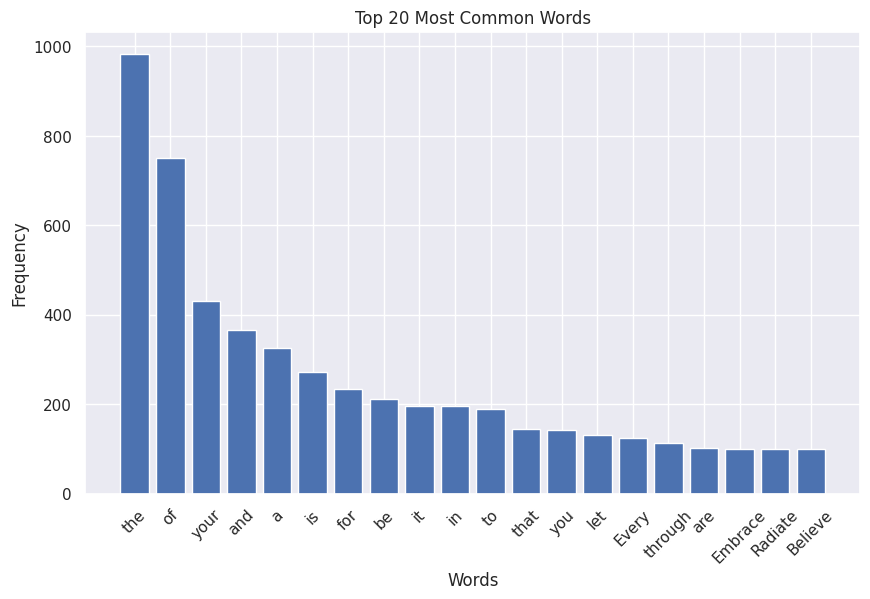

In [13]:
from collections import Counter

# Assuming 'sentences' is a list of sentences in your dataset
words = [word for sentence in eda_df["Quotes"] for word in sentence.split()]
word_freq = Counter(words)
top_20_words = dict(word_freq.most_common(20))

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [14]:
sentence_lengths = [len(sentence.split()) for sentence in eda_df["Quotes"]]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Maximum sentence length:", max(sentence_lengths))
print("Minimum sentence length:", min(sentence_lengths))

Average sentence length: 11.865
Maximum sentence length: 35
Minimum sentence length: 7


## Preprocessing

In [23]:
train, test = train_test_split(df["Quotes"], test_size=0.2, random_state=42)
train, validation = train_test_split(train, test_size=2/8, random_state=42)

In [230]:
def remove_punctuation(sentence):
    PUNC = [";", ".", ",", ":", "?", "!", "\n", "\t", "'", '"', "-"]
    output = []
    for word in sentence:
        if word not in PUNC:
            output.append(word)
    return output

def keep_joint(sentence, joiner):
    output = [sentence[0]]
    for i, word in enumerate(sentence[1:]):
        if joiner in word:
            output.pop()
            output.append(sentence[i-1]+word)
            print(i, sentence)
        else:
            output.append(word)
    return output

def remove_contractions(sentence):
    contractions = {
        "'s": "is",
        "'ve": "have",
        "'ll": "will"
    }
    output = []
    for word in sentence:
        if word in contractions:
            word = contractions[word]
        output.append(word)
    # print(output)
    return output

def clean_sentences(sentences):
    for i, sentence in enumerate(sentences):
        sentences[i] = remove_punctuation(sentence)
        # sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

def clean_sentences_for_input(sentences):
    for i, sentence in enumerate(sentences):
        # sentences[i] = remove_punctuation(sentence)
        sentences[i] = remove_contractions(sentence)
        # sentences[i] = keep_joint(sentences[i], "-")
    return sentences

In [179]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [180]:
all_words = []

for word in tokenized_quotes:
    all_words += word
    
print(f"Total word count: {len(all_words)}")

# for word in lemmatized_quotes:
#     all_words += word

all_words = list(set(all_words))

Total word count: 12205


In [181]:
for i in range(5):
    print(tokenized_quotes[i])

# for i in range(5):
#     print(lemmatized_quotes[i])
    
tokenizer = Tokenizer(split=" ", lower=True)
tokenizer.fit_on_texts([all_words])

total_words = len(tokenizer.word_index)
print(f"Number of unique words: {total_words}")
total_words += 1

max_sequence_length = 35

['Embrace', 'the', 'beauty', 'of', 'every', 'sunrise', 'it', "'s", 'a', 'fresh', 'chance', 'to', 'paint', 'your', 'world', 'with', 'joy']
['Embrace', 'challenges', 'they', 'are', 'the', 'stepping', 'stones', 'to', 'your', 'greatest', 'victories']
['Embrace', 'the', 'rhythm', 'of', 'life', 'and', 'let', 'it', 'dance', 'through', 'your', 'soul']
['Embrace', 'kindness', 'for', 'it', 'has', 'the', 'power', 'to', 'change', 'the', 'world', 'one', 'heart', 'at', 'a', 'time']
['Embrace', 'the', 'journey', 'for', 'it', 'leads', 'to', 'the', 'destination', 'of', 'your', 'dreams']
Number of unique words: 1180


In [182]:
tokenized_quotes = [[token.text for token in nlp(quote)] for quote in df["Quotes"]]
tokenized_quotes = clean_sentences(tokenized_quotes)

In [241]:
def sentences_to_data(sentences, min_sequence_length, segment, tokenize=True, verbose=0):
    # X_lemma = []
    X_word = []
    y = []
    
    # min_sequence_length = 4
    # max_sequence_length = 25
    if segment:
        for sequence in tokenized_quotes:
            for i in range(len(sequence)):
                for j in range(i+min_sequence_length, len(sequence)):
                    # X_lemma.append(" ".join(sequence[i:j]))
                    X_word.append(" ".join(sequence[i:j]))
                    y.append(sequence[j])
                    if verbose > 0:
                        if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                            print(y[-1])
    else:
        for sequence in tokenized_quotes:
            sequence = sequence[:max_sequence_length+1]
            for i in range(min_sequence_length, len(sequence)):
                X_word.append(" ".join(sequence[:i]))
                y.append(sequence[i])
                if verbose > 0:
                    if len(tokenizer.texts_to_sequences([y[-1]])[0]) != 1:
                        print(y[-1])

    sentence_lengths = [len(sentence.split(" ")) for sentence in sentences]
    print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
    print("Maximum sentence length:", max(sentence_lengths))
    print("Longest sentence: ", X_word[np.argmax(sentence_lengths)])
    print("Minimum sentence length:", min(sentence_lengths))

    if tokenize:
        X_word = tokenizer.texts_to_sequences(X_word)
        
        X_word = pad_sequences(X_word, maxlen=max_sequence_length, padding="pre")
    
    y = tokenizer.texts_to_sequences(y)
    
    if verbose > 0:
        for pred, label in zip(X_word[:5], y[:5]):
            print(f"Predictor: {pred}\nLabel: {label}")
    
    y = to_categorical(y, num_classes=total_words)
    y = y.astype(float)
    y = np.array(y)

    X_word = clean_sentences_for_input([sentence.split(" ") for sentence in X_word])
    X_word = [" ".join(sentence) for sentence in X_word]
    X_word = np.array(X_word)

    return X_word, y

In [242]:
X_train, y_train = sentences_to_data(train, 2, True, tokenize=False, verbose=1)
X_test, y_test = sentences_to_data(test, 4, False, tokenize=False, verbose=1)
X_validation, y_validation = sentences_to_data(validation, 4, False, tokenize=False, verbose=1)

Average sentence length: 11.8
Maximum sentence length: 34
Longest sentence:  the beauty of every sunrise it 's a fresh chance to paint your world with
Minimum sentence length: 7
Predictor: Embrace the
Label: [1011]
Predictor: Embrace the beauty
Label: [179]
Predictor: Embrace the beauty of
Label: [6]
Predictor: Embrace the beauty of every
Label: [146]
Predictor: Embrace the beauty of every sunrise
Label: [1032]
Average sentence length: 11.905
Maximum sentence length: 35
Longest sentence:  Embrace your dreams for they are
Minimum sentence length: 7
Predictor: Embrace the beauty of
Label: [6]
Predictor: Embrace the beauty of every
Label: [146]
Predictor: Embrace the beauty of every sunrise
Label: [1032]
Predictor: Embrace the beauty of every sunrise it
Label: [362]
Predictor: Embrace the beauty of every sunrise it 's
Label: [468]
Average sentence length: 12.02
Maximum sentence length: 29
Longest sentence:  Embrace your fears for they hold the key
Minimum sentence length: 7
Predictor: Emb

In [263]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=100,
    ngrams=2
)

vectorize_layer.adapt([" ".join(x) for x in clean_sentences_for_input(tokenized_quotes)])

In [260]:
def fit_model(model, filepath, batch_size=32, epochs=20,):
    # cp_callback = ModelCheckpoint(filepath=filepath, save_format='tf', save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
    
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        # callbacks=[cp_callback]
    )
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    
    print(f"Accuracy: {accuracy:.2f}")

    return history

# Simple LSTM

In [275]:
simple_GRU = Sequential([
    vectorize_layer,
    Embedding(total_words, 2000),
    # Flatten(),
    GRU(200, return_sequences=True),
    GRU(200),
    Dense(total_words, activation='softmax')
])

# simple_GRU = Sequential([
#     Embedding(total_words, 10000, input_length=max_sequence_length),
#     # Flatten(),
#     GRU(200, return_sequences=True),
#     GRU(200),
#     Dense(total_words, activation='softmax')
# ])

simple_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_GRU, "training_checkpoints/simple_GRU_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
241/241 [==============================] - 18s 70ms/step - loss: 5.3053 - accuracy: 0.1097 - val_loss: 4.5097 - val_accuracy: 0.2204
Epoch 2/20
241/241 [==============================] - 11s 44ms/step - loss: 3.6461 - accuracy: 0.3543 - val_loss: 2.6922 - val_accuracy: 0.4849
Epoch 3/20
241/241 [==============================] - 10s 40ms/step - loss: 2.4083 - accuracy: 0.5081 - val_loss: 1.8596 - val_accuracy: 0.5963
Epoch 4/20
241/241 [==============================] - 9s 37ms/step - loss: 1.7920 - accuracy: 0.5908 - val_loss: 1.3832 - val_accuracy: 0.6656
Epoch 5/20
241/241 [==============================] - 9s 37ms/step - loss: 1.4291 - accuracy: 0.6501 - val_loss: 1.1022 - val_accuracy: 0.7185
Epoch 6/20
241/241 [==============================] - 9s 37ms/step - loss: 1.2029 - accuracy: 0.6892 - val_loss: 0.9048 - val_accuracy: 0.7528
Epoch 7/20
241/241 [==============================] - 9s 38ms/step - loss: 1.0561 - accuracy: 0.7177 - val_loss: 0.7721 - val_accuracy: 0.7

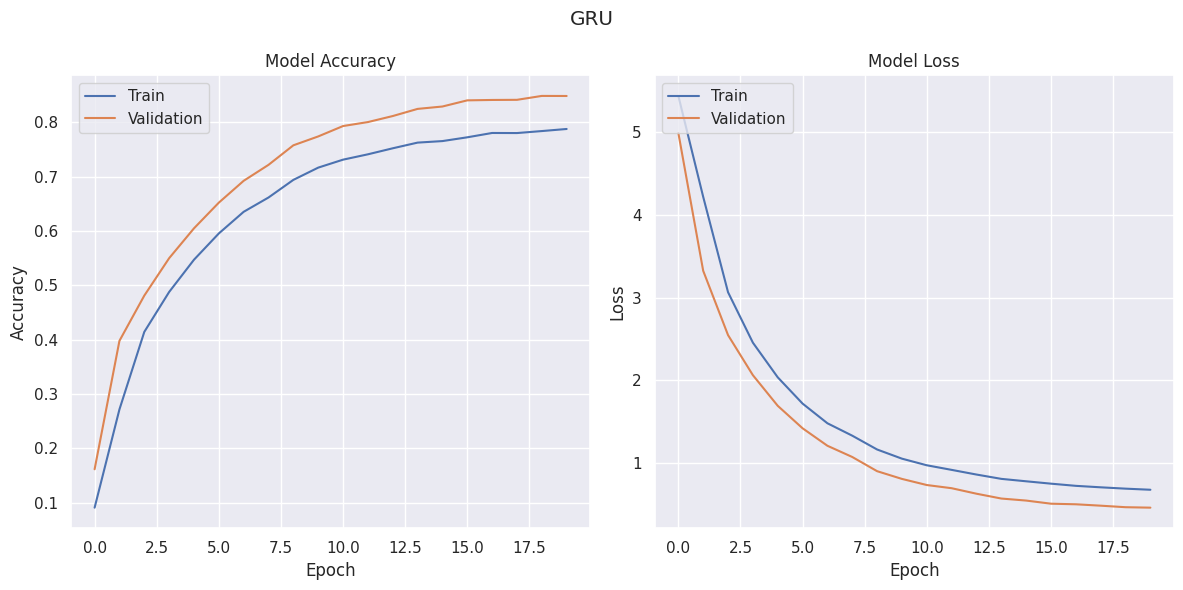

In [274]:
plot_history(history, "GRU")

In [198]:
max_vocab_size = 10000

vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=200
)

vectorize_layer.adapt([" ".join(x) for x in tokenized_quotes])

simple_LSTM = Sequential([
    vectorize_layer,
    Embedding(total_words, 100),
    # Flatten(),
    LSTM(200, return_sequences=True),
    LSTM(200),
    Dense(total_words, activation='softmax')
])


simple_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# history = model.fit(, epochs=50, verbose=1, batch_size=128, validation_data=(X_validation, y_validation))

history = fit_model(simple_LSTM, "training_checkpoints/simple_LSTM_weights.{epoch:02d}-{val_accuracy:.2f}.h5", batch_size=256, epochs=20)

Epoch 1/20
 49/241 [=====>........................] - ETA: 57s - loss: 5.6612 - accuracy: 0.0728

KeyboardInterrupt: 

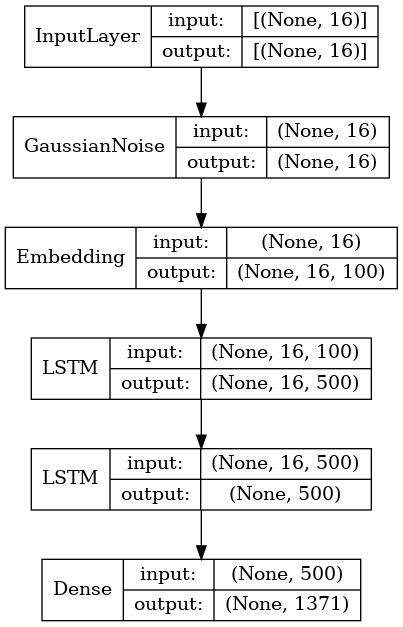

In [117]:
plot_model(simple_RNN, to_file='images/models/simple_LSTM.png', show_shapes=True, show_layer_names=False)

In [273]:
def plot_history(history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    fig.suptitle(title)
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')

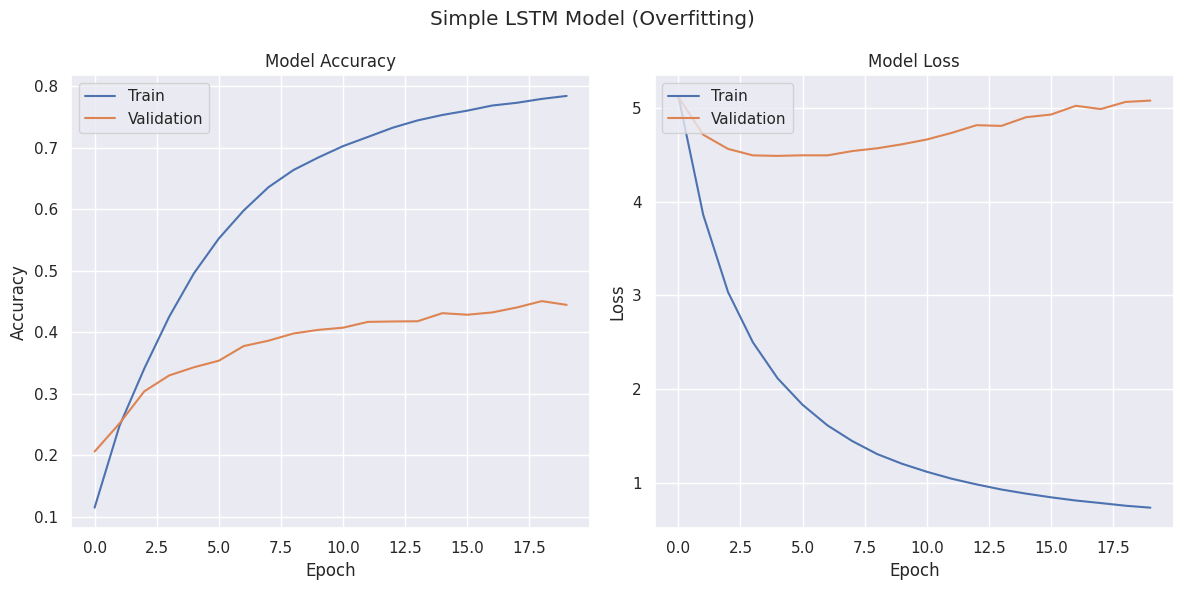

In [104]:
plot_history(history, "Simple LSTM Model (Overfitting)", "images/Simple LSTM Model (Overfitting).png")

* The model is unable to generalise and severely overfits on the training set.

In [45]:
# Attention is all you need

inputs = tf.keras.layers.Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=total_words, output_dim=2000)(inputs)
lstm_layer = GRU(200, return_sequences=True)(embedding_layer)

attention = Attention(use_scale=True)([lstm_layer, lstm_layer])
context_vector = tf.reduce_sum(attention * lstm_layer, axis=1)

output = Dense(total_words, activation='softmax')(context_vector)

attention_model = Model(inputs=inputs, outputs=output)

attention_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(attention_model, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

Epoch 1/50
153/153 [==============================] - ETA: 0s - loss: 5.6172 - accuracy: 0.0888
Epoch 1: val_loss improved from inf to 5.49605, saving model to training_checkpoints/simple_RNN_weights.01-0.09.hdf5
153/153 [==============================] - 4s 23ms/step - loss: 5.6172 - accuracy: 0.0888 - val_loss: 5.4960 - val_accuracy: 0.0930
Epoch 2/50
153/153 [==============================] - ETA: 0s - loss: 5.0289 - accuracy: 0.1218
Epoch 2: val_loss improved from 5.49605 to 5.24764, saving model to training_checkpoints/simple_RNN_weights.02-0.14.hdf5
153/153 [==============================] - 2s 12ms/step - loss: 5.0289 - accuracy: 0.1218 - val_loss: 5.2476 - val_accuracy: 0.1417
Epoch 3/50
153/153 [==============================] - ETA: 0s - loss: 4.5129 - accuracy: 0.1549
Epoch 3: val_loss improved from 5.24764 to 5.01739, saving model to training_checkpoints/simple_RNN_weights.03-0.18.hdf5
153/153 [==============================] - 2s 11ms/step - loss: 4.5129 - accuracy: 0.1549

KeyboardInterrupt: 

In [ ]:
attention_model.summary()

In [276]:
# Build the model
simple_RNN3 = Sequential([
    # GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    Bidirectional(LSTM(50, return_sequences=True)),
    # LSTM(50, return_sequences=True),
    
    Attention(),
    Dropout(0.3),
    Dense(1000),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN3, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=50)

ValueError: Exception encountered when calling layer "attention_3" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 35, 50), dtype=float32).

Call arguments received by layer "attention_3" (type Attention):
  • inputs=tf.Tensor(shape=(None, 35, 50), dtype=float32)
  • mask=None
  • training=None
  • return_attention_scores=False
  • use_causal_mask=False

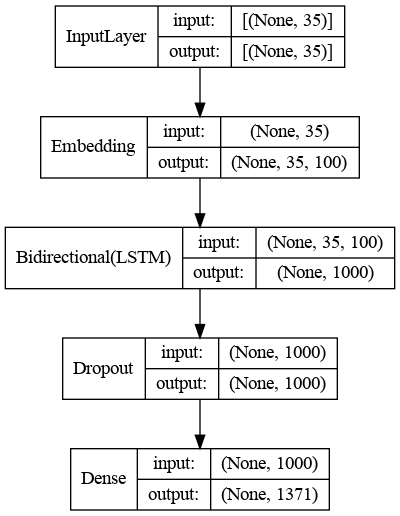

In [260]:
plot_model(simple_RNN3, show_shapes=True, show_layer_names=False)

In [124]:
# Build the model
simple_RNN2 = Sequential([
    GaussianNoise(0.5),
    Embedding(total_words, 100, input_length=max_sequence_length),
    LSTM(100),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
])
simple_RNN2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = fit_model(simple_RNN2, "training_checkpoints/simple_RNN_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5", epochs=20)

Epoch 1/20
389/389 [==============================] - ETA: 0s - loss: 5.3696 - accuracy: 0.0935
Epoch 1: val_loss improved from inf to 5.39246, saving model to training_checkpoints/simple_RNN_weights.01-0.12.hdf5
389/389 [==============================] - 18s 44ms/step - loss: 5.3696 - accuracy: 0.0935 - val_loss: 5.3925 - val_accuracy: 0.1245
Epoch 2/20
388/389 [============================>.] - ETA: 0s - loss: 4.6576 - accuracy: 0.1743
Epoch 2: val_loss improved from 5.39246 to 4.96396, saving model to training_checkpoints/simple_RNN_weights.02-0.21.hdf5
389/389 [==============================] - 15s 38ms/step - loss: 4.6567 - accuracy: 0.1743 - val_loss: 4.9640 - val_accuracy: 0.2063
Epoch 3/20
388/389 [============================>.] - ETA: 0s - loss: 4.1654 - accuracy: 0.2235
Epoch 3: val_loss improved from 4.96396 to 4.73630, saving model to training_checkpoints/simple_RNN_weights.03-0.25.hdf5
389/389 [==============================] - 13s 35ms/step - loss: 4.1646 - accuracy: 0.2

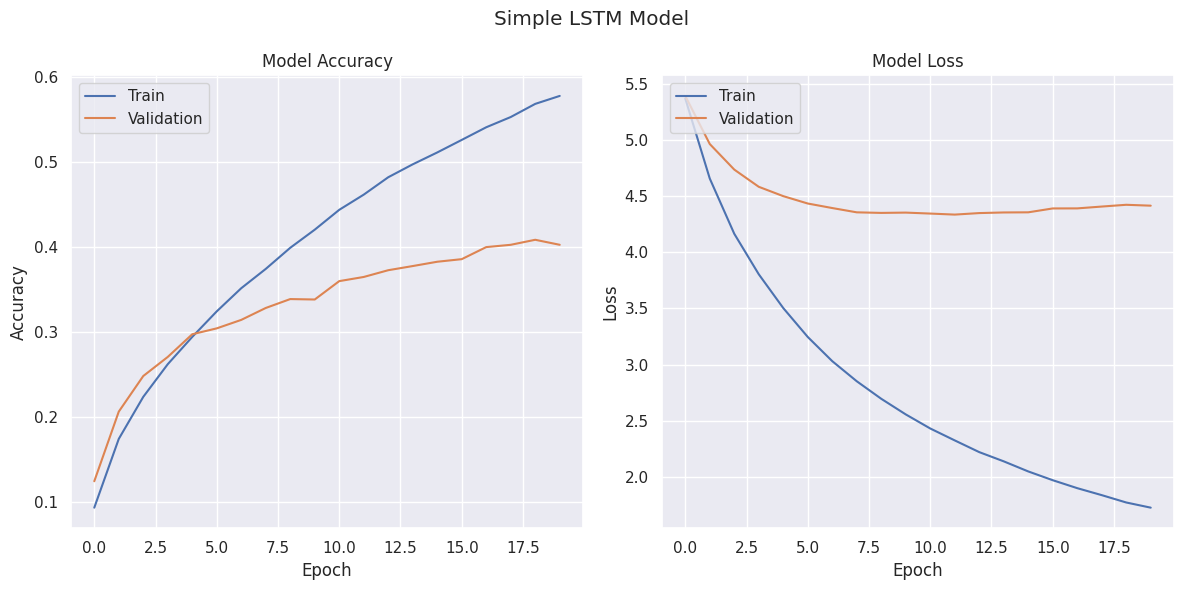

In [125]:
plot_history(history, "Simple LSTM Model")

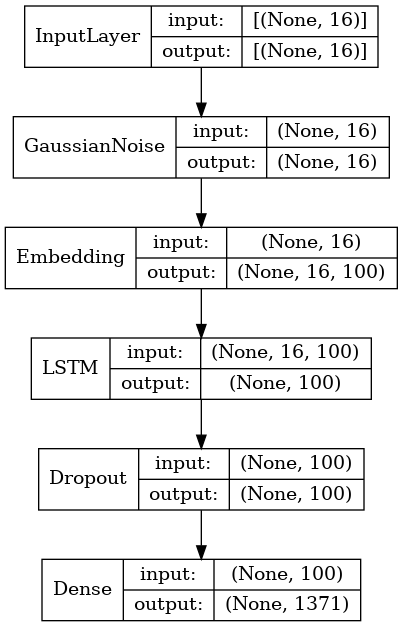

In [126]:
plot_model(simple_RNN2, to_file='images/models/simple_RNN2.png', show_shapes=True, show_layer_names=False)

In [264]:
def predict_next_word(model, seed_text, next_words=1):
    for _ in range(next_words):
        seed_text = [token.text for token in nlp(seed_text)]
        seed_text = " ".join(clean_sentences_for_input(clean_sentences([seed_text]))[0])

        # print(seed_text)
        
        # token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')
        predicted_index = np.argmax(model.predict([seed_text], verbose=0), axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                predicted_word = word
                break
        seed_text += " " + predicted_word
    return seed_text

# Example usage
# seed_text = "embrace each day"
# predicted_text = predict_next_word(simple_RNN3, seed_text, next_words=10)
# print(predicted_text)

In [37]:
seed_texts = [
    'embrace each day',
    'radiate some',
    'believe that',
    "life's actual purpose is",
    'dance through each and every',
    'let your time and energy',
    'every person is',
    'our country Singapore is',
    'planet earth is',
    'morning and evening would make it'
]

for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_LSTM, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a reminder of the beauty in our differences and
radiate some is the music of a joyful heart glimpse the power
believe that for it waters the seeds of your aspirations and reality
life 's actual purpose is a tapestry woven with threads of love and hope and
dance through each and every how it illuminates the seeds of your soul and fresh
let your time and energy for it is a beacon of hope and hope and
every person is a step towards excellence and progress and you and the
our country Singapore is a step towards excellence and progress and you and the
planet earth is the echoes of a joyful heart glimpse the power of
morning and evening would make it to the wonders of the world we hear the power


In [391]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(attention_model, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for it paint with vibrant heart with
radiate some for it is the heartbeat of your life well lived
believe that yourself for it is the spark that forward forward transformation
life 's actual purpose is a bridge that connects hearts to your future for others
dance through each and every savoring a joyful one one one gift that its time
let your time and energy the ripple that cuts creates doubt connections sun sun meet
every person is a has a power to the world of life 's
our country Singapore is a precious set that words and let go go of
planet earth is the precious heartbeat of our life 's gardens embrace from
morning and evening would make it has the potential to make a difference holds the magic


In [389]:
print("hello")

hello


In [159]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for new beginnings and fresh opportunities and
radiate some for it is the key to unlocking a bright future
believe that cuts through fear brings your way to success knows no
life 's actual purpose is a step towards miracles the extraordinary moments that defy logic
dance through each and every to navigate your path with purpose and determination shape destinies
let your time and energy flourish hold the keys to your potential and possibility your
every person is marine species protect the treasures of our planet 's future
our country Singapore is a treasure trove singapore 's nature is a sanctuary to
planet earth is a gateway to a brighter future in the realization of
morning and evening would make it 's journey and adventures to the soul from the chains


In [276]:
for seed_text in seed_texts:
    predicted_text = predict_next_word(simple_GRU, seed_text, next_words=10)
    print(predicted_text)

embrace each day is a canvas for new beginnings and uplifts part hearts
radiate some and soul you encounter to navigate navigate singapore is energy
believe that soothes wounded hearts souls souls that present of us of
life is actual purpose is to stronger and uplift to navigate the of a nation
dance through each and every shore of your heart this morning find the power of
let your time and energy in the universe a reminder of the marvel the marvel
every person is a step towards excellence witnessing miracles the extraordinary moments that
our country Singapore is strength and grace and gratitude in the moment of gratitude
planet earth is are for the stars a a a of and a
morning and evening would make it can transform and are in harmony nurtured stronger stronger you
